In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

In [2]:
#general settings
LSST = True
#if not LSST redhsift kernel
chi0 = chi_cmb/6.
sigma_chi = chi_cmb/14.
bin_num = 'all'
# z_lens = 0.5
chimax  = chi_cmb


delta_lensing = True # set to False for galaxy lensing
gal_bin = None

if not delta_lensing:
        dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'
        if gal_bin is "all":
            zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
            chi_low = min(1e-2,chi_z(min(zbin)))
            chi_hi  = chi_z(max(zbin))
        else:
            bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
            chi_low = max(chi_z(bins[gal_bin][0]-2*bins[gal_bin][2]),0.)
            if gal_bin<4:
                chi_hi  = chi_z(bins[gal_bin+1][0]+2.*bins[gal_bin+1][2])
            else:
                chi_hi  = chi_z(bins[gal_bin][0]+1.5)

if LSST:
    if delta_lensing: 
        if chimax==chi_cmb:
            file_ext = 'lsst%s_cmblens'%str(bin_num)
        else:
            file_ext = 'lsst%s_deltalens_z%.0e'%str(bin_num,z_lens)
    else:
        file_ext = 'lsst%s_lensbin_%s'%str(bin_num,gal_bin)
else:
    if delta_lensing: 
        if chimax==chi_cmb:
            file_ext = 'gaussgal_chi0%d_sigmachi%d_cmblens'%(chi0,sigma_chi)
        else:
            file_ext = 'gaussgal_chi0%d_sigmachi%d_deltalens_z%.0e'%str(chi0,sigma_chi,z_lens) 
print(file_ext)



lsstall_cmblens


In [7]:
if delta_lensing:
    print('delta lensing with chimax %d'%chimax)
    def lensing_kernel(xi):
        xmax = chimax
        return (xmax - xi)/(xmax*xi) * (xmax > xi)
else:
    print('galaxy lensing with bin %s'%str(gal_bin))
    p_z_lens = dNdz_LSST(gal_bin)
    lensing_kernel = gal_lens(p_z_lens,chimin=max(1e-2,chi_low),chimax=chi_hi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = Gauss_chi(chi0,sigma_chi)
    def galax_kernel(x):
        return kernel(x)*simple_bias(x)
        
def inner_kernel(xi,xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)

delta lensing with chimax 9414


### 1) Non-Limber Terms Equations 4.6-4.7

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{\delta\phi}(\chi',\chi'')\\
= 2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi W(\chi,\chi_{CMB}) \int_0^\chi \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{g\phi}(\chi'') $




In [4]:
chimaxs = np.load('../G_matrices/clphigalchimaxs_VB.npy')
clgphi  = np.load('../G_matrices/clphigal_VB.npy')
#check if chimaxs are in correct order


r2d, t2d = np.meshgrid(t_,t_)
np.prod((chimaxs==r2d*t2d*chi_cmb))

1

In [5]:
clgphi_Chirag = np.load('../output/cm_clmesh/clphideltacmb_1plusz.npy')

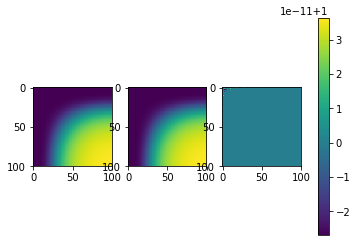

In [6]:
fig, ax = plt.subplots(ncols=3,nrows=1)
a = ax[0].imshow(clgphi_Chirag[10])
b = ax[1].imshow(clgphi[10])
c = ax[2].imshow(clgphi_Chirag[10]/clgphi[10])
fig.colorbar(c, ax=ax)


In [8]:


try:
    _, M31b = np.load('../M_matrices/M31b_%s.npy'%str(file_ext))
except:

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clgphi_  = np.expand_dims(clgphi,-1)


    result   = np.zeros((len(ell_),len(ell_)))

    chimax   = chi_cmb

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = inner_kernel(r2d*t2d*chimax,chimax*r2d)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax))*clgphi_[nn]

        chi2fac0  = chi2fac00

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])

    print(time.time()-begin)

    M31b = chimax * result*1./np.pi**2/2.*prefac**2/4.

    #first index L, second index l
    np.save('../M_matrices/M31b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M31b])
# to do: check if l grids are correct

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
425.195880175


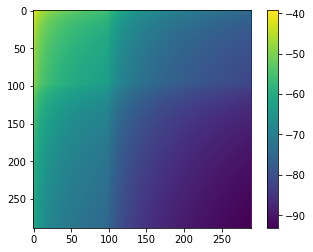

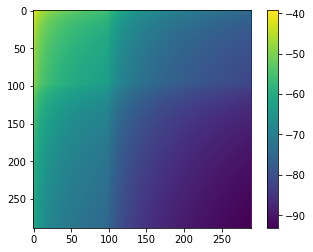

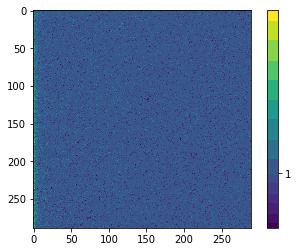

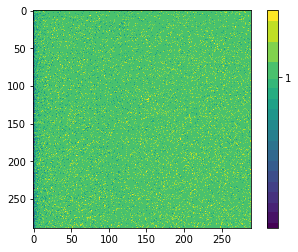

1.4065668404881894e-16

In [9]:
MB1_Chirag = np.load('../output/cm_clmesh/cl31b_1plusz.npy')

M31b_spline = RectBivariateSpline(ell_,ell_,M31b)
plt.imshow(np.log(M31b))
plt.colorbar()
plt.show()
plt.imshow(np.log(MB1_Chirag))
plt.colorbar()
plt.show()

plt.imshow((MB1_Chirag/M31b))
plt.colorbar()
plt.show()

plt.imshow((M31b/MB1_Chirag))
plt.colorbar()
plt.show()

np.mean(M31b/MB1_Chirag)
np.std(M31b/MB1_Chirag)

In [14]:
# Eq. 5.6

L = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)

def l_integration_1(M,L,l):
    return 2.*L**2*np.trapz(l**5*M(L,l),l)/4./np.pi


In [27]:
res=[]
for LL in L:
    res+=[l_integration_1(M31b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term3_%s.npy'%file_ext,[L,res])

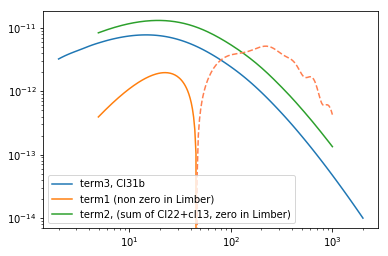

In [36]:
L1, term1 = np.load('../output/results/term1_%s.npy'%file_ext)
L2, term2 = np.load('../output/results/term2_%s.npy'%file_ext)
plt.loglog(L,res,label='term3, Cl31b')
plt.loglog(L1,term1,label='term1 (non zero in Limber)')
plt.loglog(L2,term2,label='term2, (sum of Cl22+cl13, zero in Limber)')
plt.loglog(L2,-term1,c='coral',ls='--')
plt.legend()


Term 2:
$-2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\psi}(\chi'',\chi)   C_l^{\delta\phi}(\chi',\chi'')\\
= -2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi'  W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\phi}(\chi'')   C_l^{\delta_h \phi}(\chi',\chi'') $

In [37]:
clphidelta  = np.load('../G_matrices/clphidelta_parallel_MB2.npy')

clphipsi    = np.load('../G_matrices/clpsiphi_parallel_MB2.npy')

print(clphidelta.shape)
print(clphipsi.shape)

(289, 100, 100)
(289, 100, 100)


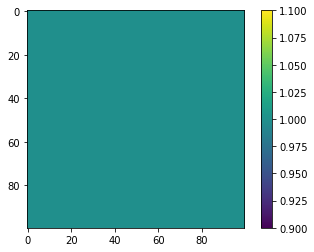

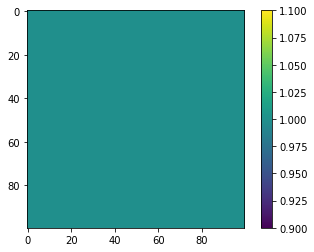

In [38]:
chimaxs = np.load('../G_matrices/clphidelta_parallel_MB2_chimaxs.npy')
r2d, t2d = np.meshgrid(t_,t_)
chimaxs3 = r2d*t2d*chi_cmb
chimaxs2 =  t_.reshape(-1, 1)*t_.reshape(1, -1)*chi_cmb
plt.imshow(chimaxs2/chimaxs)
plt.colorbar()
plt.show()
plt.imshow(chimaxs2/chimaxs3)
plt.colorbar()
plt.show()



In [39]:
clphidelta_Chirag  = np.load('../output/cm_clmesh/cldeltachiphi.npy')
clphipsi_Chirag   = np.load('../output/cm_clmesh/clpsiphicmb.npy')

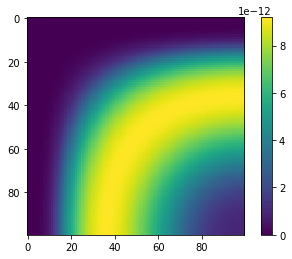

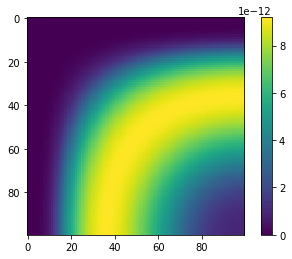

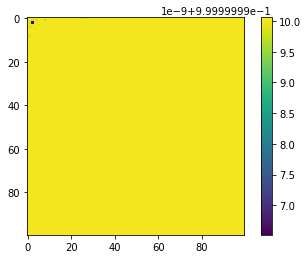

In [40]:
r2d, t2d = np.meshgrid(t_,t_)
plt.imshow(clphipsi[10])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(clphipsi_Chirag[10]*(1+z_chi(r2d*t2d*chi_cmb)))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(clphipsi_Chirag[10]*(1+z_chi(r2d*t2d*chi_cmb))/clphipsi[10])
plt.colorbar()

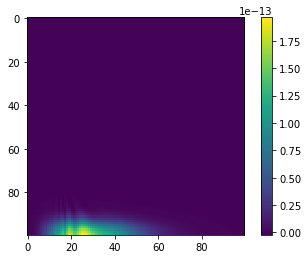

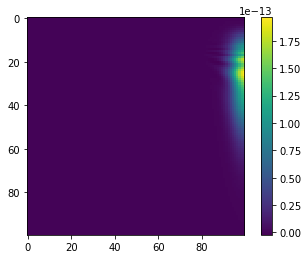

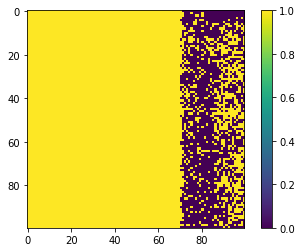

In [41]:
plt.imshow(clphidelta[100])
plt.colorbar()
plt.show()
plt.imshow(clphidelta_Chirag[100])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(clphidelta_Chirag[100]==clphidelta[100].T)
plt.colorbar()
plt.show()


In [43]:
try:
    _, M13b = np.load('../M_matrices/M13b_%s.npy'%str(file_ext))
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)*(1+z_chi(xi))

    kernel2 = inner_kernel
    kernel1 = galax_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)


    result   = np.zeros((len(ell_),len(ell_)))

    chimax   = chi_cmb

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = kernel1(r2d*chimax)
        chi1fac0 = chi1fac0*(r2d*chimax)

        chi2fac0 = kernel2(r2d*t2d*chimax,chimax*r2d)*clphipsi_Chirag[nn]
        chifacs  = w11*w12*chi1fac0*chi2fac0

        for ii  in range(len(ell_)):        
            result[nn][ii] = np.sum(chifacs*clphidelta_Chirag[ii].T)

    #first index is
    M13b = chi_cmb*result/4.

    np.save('../M_matrices/M13b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M13b])
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)

In [47]:


def inner_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

kernel2 = inner_kernel
kernel1 = lsst_kernel_cb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)


result   = np.zeros((len(ell_),len(ell_)))

chimax   = chi_cmb

n = 0

begin=time.time()
for nn in range(len(ell_)):
    if nn%10==0:
        print(nn)
    chi1fac0 = kernel1(r2d*chimax)
    chi1fac0 = chi1fac0*(r2d*chimax)

    chi2fac0 = kernel2(r2d*t2d*chimax,chimax*r2d)*clphipsi[nn]
    chifacs  = w11*w12*chi1fac0*chi2fac0

    for ii  in range(len(ell_)):        
        result[nn][ii] = np.sum(chifacs*clphidelta[ii])

#first index is
MB2 = chi_cmb*result/4.

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


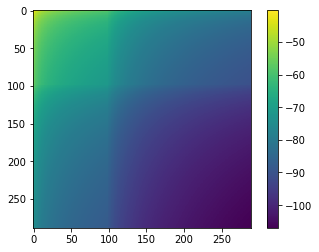

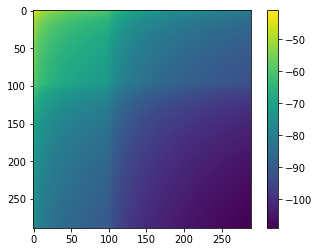

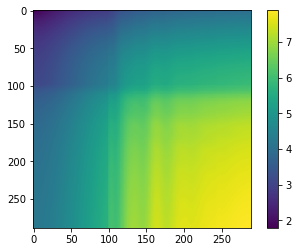

In [49]:
plt.imshow(np.log(M13b))
plt.colorbar()
plt.show()
MB_Chirag = np.load('../output/cm_clmesh/cl13b.npy')
plt.imshow(np.log(MB_Chirag))
plt.colorbar()
plt.show()
plt.imshow(M13b/MB_Chirag)
plt.colorbar()


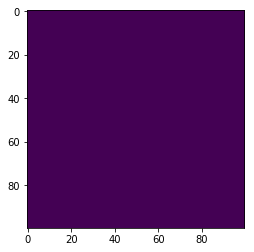

In [22]:
r1d, t1d = t_.reshape(1, -1), t_.reshape(-1, 1)
w11, w12 = w1.reshape(1, -1), w1.reshape(-1, 1)
grid = r1d*t1d*chi_cmb
plt.imshow(grid/(r2d*t2d*chi_cmb))
plt.show()

In [24]:
MB2 = RectBivariateSpline(ell_,ell_,MB1)

In [25]:
def l_integration_2(M,L,l):
    return -L**4*np.trapz(l**3*M(L,l),l)/2./np.pi

In [26]:
res=[]
for LL in L:
    res+=[l_integration_2(MB2,LL,l)]
res = np.asarray(res)

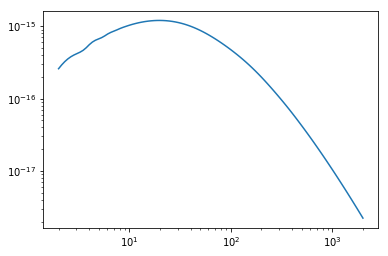

In [27]:
plt.loglog(L,-res)

Term 3:
$C_{13,\rm{J}}^{(\kappa g)}(L) = - \frac{1}{2} \int \frac{d^2 l}{(2 \pi)^2} l^2 L^4 \int_0^{\chi_{max}} d \chi \, W_h(\chi) C_L^{\phi \phi}(\chi,\chi_{CMB}) C^{\phi\delta_h}_{l}(\chi)$


In [33]:
clphiphi = np.load('../G_matrices/clphiphi_parallel.npy')
r2d, t2d = np.meshgrid(t_,t_)
#test for symmetry
for ii in range(len(ell_)):
    if (np.all((clphiphi[ii,:,-1]-clphiphi[0,-1,:])/clphiphi[ii,-1,:]>1e-3)):
        print(ii)
    if (np.all((clphiphi[ii,:,-1]-clphiphi[0,-1,:])/clphiphi[ii,:,-1]>1e-3)):
        print(ii)
clphiphi_xi_xi_cmb=clphiphi[:,:,-1]

In [37]:
clphidelta = np.load('../G_matrices/clphidelta.npy')
clphidelta_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphidelta_diag[:,ii] = clphidelta[:,ii,ii]

In [46]:
kernel1 = lsst_kernel_cb
result = np.zeros((len(ell_),len(ell_)))
for ii in range(len(ell_)):
    for jj in range(len(ell_)):
        result[ii][jj] = chi_cmb*np.sum(w1*kernel1(t_*chi_cmb)*clphidelta_diag[ii]*clphiphi_xi_xi_cmb[jj])/2.

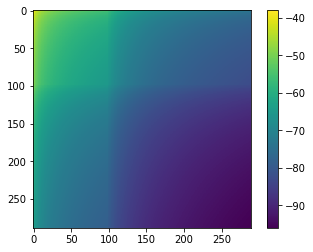

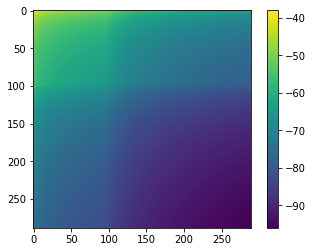

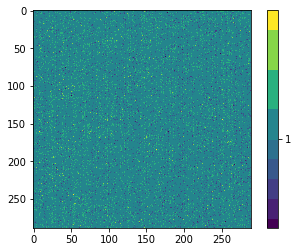

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [47]:
res_chirag = np.load('../output/cm_clmesh/cl13j.npy')
plt.imshow(np.log(result))
plt.colorbar()
plt.show()
plt.imshow(np.log(res_chirag))
plt.colorbar()
plt.show()
plt.imshow((res_chirag/result.T))
plt.colorbar()
plt.show()

res_chirag/result.T

In [31]:
MB3 = RectBivariateSpline(ell_,ell_,result)

In [32]:
def l_integration_3(M,L,l):
    return 2*L**4*np.trapz(l**3*M(L,l),l)/2./np.pi

In [33]:
res=[]
for LL in L:
    res+=[l_integration_2(MB2,LL,l)]
res = np.asarray(res)

In [97]:
test = np.stack(np.arange(5) for ii in range(10))

In [98]:
test.shape

(10, 5)

In [99]:
test[0]

array([0, 1, 2, 3, 4])

In [100]:
np.meshgrid(t_[:50],t_)

[array([[  1.43136613e-04,   7.54024680e-04,   1.85243263e-03, ...,
           4.60965709e-01,   4.76564159e-01,   4.92185508e-01],
        [  1.43136613e-04,   7.54024680e-04,   1.85243263e-03, ...,
           4.60965709e-01,   4.76564159e-01,   4.92185508e-01],
        [  1.43136613e-04,   7.54024680e-04,   1.85243263e-03, ...,
           4.60965709e-01,   4.76564159e-01,   4.92185508e-01],
        ..., 
        [  1.43136613e-04,   7.54024680e-04,   1.85243263e-03, ...,
           4.60965709e-01,   4.76564159e-01,   4.92185508e-01],
        [  1.43136613e-04,   7.54024680e-04,   1.85243263e-03, ...,
           4.60965709e-01,   4.76564159e-01,   4.92185508e-01],
        [  1.43136613e-04,   7.54024680e-04,   1.85243263e-03, ...,
           4.60965709e-01,   4.76564159e-01,   4.92185508e-01]]),
 array([[  1.43136613e-04,   1.43136613e-04,   1.43136613e-04, ...,
           1.43136613e-04,   1.43136613e-04,   1.43136613e-04],
        [  7.54024680e-04,   7.54024680e-04,   7.54024680e-0